<a href="https://colab.research.google.com/github/AdamPeetz/stable_diffusion/blob/main/image_enhancing_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [16]:
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"

**Defining Helper Functions**

In [21]:
def load_image(image_path):
  input_image = tf.image.decode_image(tf.io.read_file(image_path))
  if input_image.shape[-1] == 4:
    input_image = input_image[...,:-1]
  input_image = tf.cast(input_image, tf.float32)
  return tf.expand_dims(input_image,0)

In [22]:
directory_path = "/content/gdrive/My Drive/planegan/sample_output_2/"
image_lst = []
for file in os.listdir(directory_path):
  add_image = load_image(os.path.join(directory_path,file))
  image_lst.append(add_image)

In [ ]:
image_lst[1]

#### Performing Super Resolution of images loaded from path

In [17]:
model = hub.load(SAVED_MODEL_PATH)

Downloaded https://tfhub.dev/captain-pool/esrgan-tf2/1, Total size: 20.60MB



In [ ]:
start = time.time()
counter = 0
for idx in range(len(image_lst)):
  fake_image = model(image_lst[idx])
  fake_image = tf.squeeze(fake_image)
  image = np.asarray(fake_image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.figure(figsize=(20,20))
  plt.imshow(image)
  plt.axis('off')
  filename = '/content/gdrive/My Drive/planegan/sample_output_2/generated_plot_%05d.png' % (counter+1)
  plt.savefig(filename, transparent=True,bbox_inches="tight",pad_inches=0.0 )
  plt.close()
  counter += 1
print("Time Taken: %f" % (time.time() - start))

Saved as Super Resolution.jpg


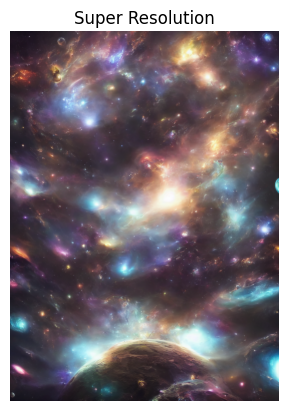

In [ ]:
# Plotting Super Resolution Image
plot_image(tf.squeeze(fake_image), title="Super Resolution")
save_image(tf.squeeze(fake_image), filename="Super Resolution")

hr_image.shape

In [ ]:
image = np.asarray(fake_image)
image = tf.clip_by_value(image, 0, 255)
image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
plt.figure(figsize=(100,100))
plt.imshow(image)
plt.axis('off')
filename = '/content/gdrive/My Drive/planegan/sample_output/generated_plot'
plt.savefig(filename, transparent=True,bbox_inches="tight",pad_inches=0.0 )
plt.close()


### Evaluating Performance of the Model

In [ ]:
!wget "https://lh4.googleusercontent.com/-Anmw5df4gj0/AAAAAAAAAAI/AAAAAAAAAAc/6HxU8XFLnQE/photo.jpg64" -O test.jpg
IMAGE_PATH = "test.jpg"

In [ ]:
# Defining helper functions
def downscale_image(image):
  """
      Scales down images using bicubic downsampling.
      Args:
          image: 3D or 4D tensor of preprocessed image
  """
  image_size = []
  if len(image.shape) == 3:
    image_size = [image.shape[1], image.shape[0]]
  else:
    raise ValueError("Dimension mismatch. Can work only on single image.")

  image = tf.squeeze(
      tf.cast(
          tf.clip_by_value(image, 0, 255), tf.uint8))

  lr_image = np.asarray(
    Image.fromarray(image.numpy())
    .resize([image_size[0] // 4, image_size[1] // 4],
              Image.BICUBIC))

  lr_image = tf.expand_dims(lr_image, 0)
  lr_image = tf.cast(lr_image, tf.float32)
  return lr_image

In [ ]:
hr_image = preprocess_image(IMAGE_PATH)

In [ ]:
lr_image = downscale_image(tf.squeeze(hr_image))

In [ ]:
# Plotting Low Resolution Image
plot_image(tf.squeeze(lr_image), title="Low Resolution")

In [ ]:
model = hub.load(SAVED_MODEL_PATH)

In [ ]:
start = time.time()
fake_image = model(lr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

In [ ]:
plot_image(tf.squeeze(fake_image), title="Super Resolution")
# Calculating PSNR wrt Original Image
psnr = tf.image.psnr(
    tf.clip_by_value(fake_image, 0, 255),
    tf.clip_by_value(hr_image, 0, 255), max_val=255)
print("PSNR Achieved: %f" % psnr)

**Comparing Outputs size by side.**

In [ ]:
plt.rcParams['figure.figsize'] = [15, 10]
fig, axes = plt.subplots(1, 3)
fig.tight_layout()
plt.subplot(131)
plot_image(tf.squeeze(hr_image), title="Original")
plt.subplot(132)
fig.tight_layout()
plot_image(tf.squeeze(lr_image), "x4 Bicubic")
plt.subplot(133)
fig.tight_layout()
plot_image(tf.squeeze(fake_image), "Super Resolution")
plt.savefig("ESRGAN_DIV2K.jpg", bbox_inches="tight")
print("PSNR: %f" % psnr)